## PPO: Proximal Policy Optimization Algorithms

[Paper: Proximal Policy Optimization](https://arxiv.org/pdf/1707.06347)

[Youtube: Natural Policy Gradients, TRPO, PPO](https://www.youtube.com/watch?v=xvRrgxcpaHY)

https://www.youtube.com/watch?v=k2pD3k1485A


### 1. Introduction
PPO优势：
- A novel objective function that enables multiple epochs of minibatch updates, whereas standard PG methods perform one gradient update per data sample.
- TRPO的优点但是更简单、better sample complexity
    

### 2.1 Policy Gradient Methods
目标奖励函数：
$$L^{PG}(\theta) = \hat{\mathbb{E}}[log\pi_{\theta}(a_t|s_t)\hat{A}_t]$$


## 2.2 TRPO
目标奖励函数：
$$\underset{\theta}{maxmize}\quad\hat{\mathbb{E}}[\cfrac{\pi_{\theta}(a_t|s_t)}{\pi_{\theta_{old}}(a_t|s_t)}\hat{A}_t]$$
$$s.t.\quad \hat{\mathbb{E}}_t[KL[\pi_{\theta_{old}}(*|s_t), \pi_{\theta_{old}}(*|s_t)]]\le \delta$$

## 3. PPO 1 : Clipped Surrogate Objective
importance sampling ratio : $r_t(\theta) = \cfrac{\pi_{\theta}(a_t|s_t)}{\pi_{\theta_{old}}(a_t|s_t)}$, so $r_{old}({\theta})=1$。\
#### TRPO最大化代理目标函数：
$$L^{CPI}(\theta) = \hat{\mathbb{E}}[\cfrac{\pi_{\theta}(a_t|s_t)}{\pi_{\theta_{old}}(a_t|s_t)}\hat{A}_t] = \hat{\mathbb{E}}[r_t(\theta)\hat{A}_t]$$

#### PPO最大化下面代理目标函数：
$$L^{CLIP}(\theta) = \hat{\mathbb{E}}[min(r_t(\theta)\hat{A}_t, clip(r_t(\theta), 1-\epsilon, 1+\epsilon)\hat{A_t}]$$

如果没有约束条件，最大化$L^{CPI}$将会导致excessively large policy update, 因此需要考虑如何**修改上述目标函数以惩罚policy changes that move $r_t(\theta)$ away from 1**

* $L^{CLIP}$
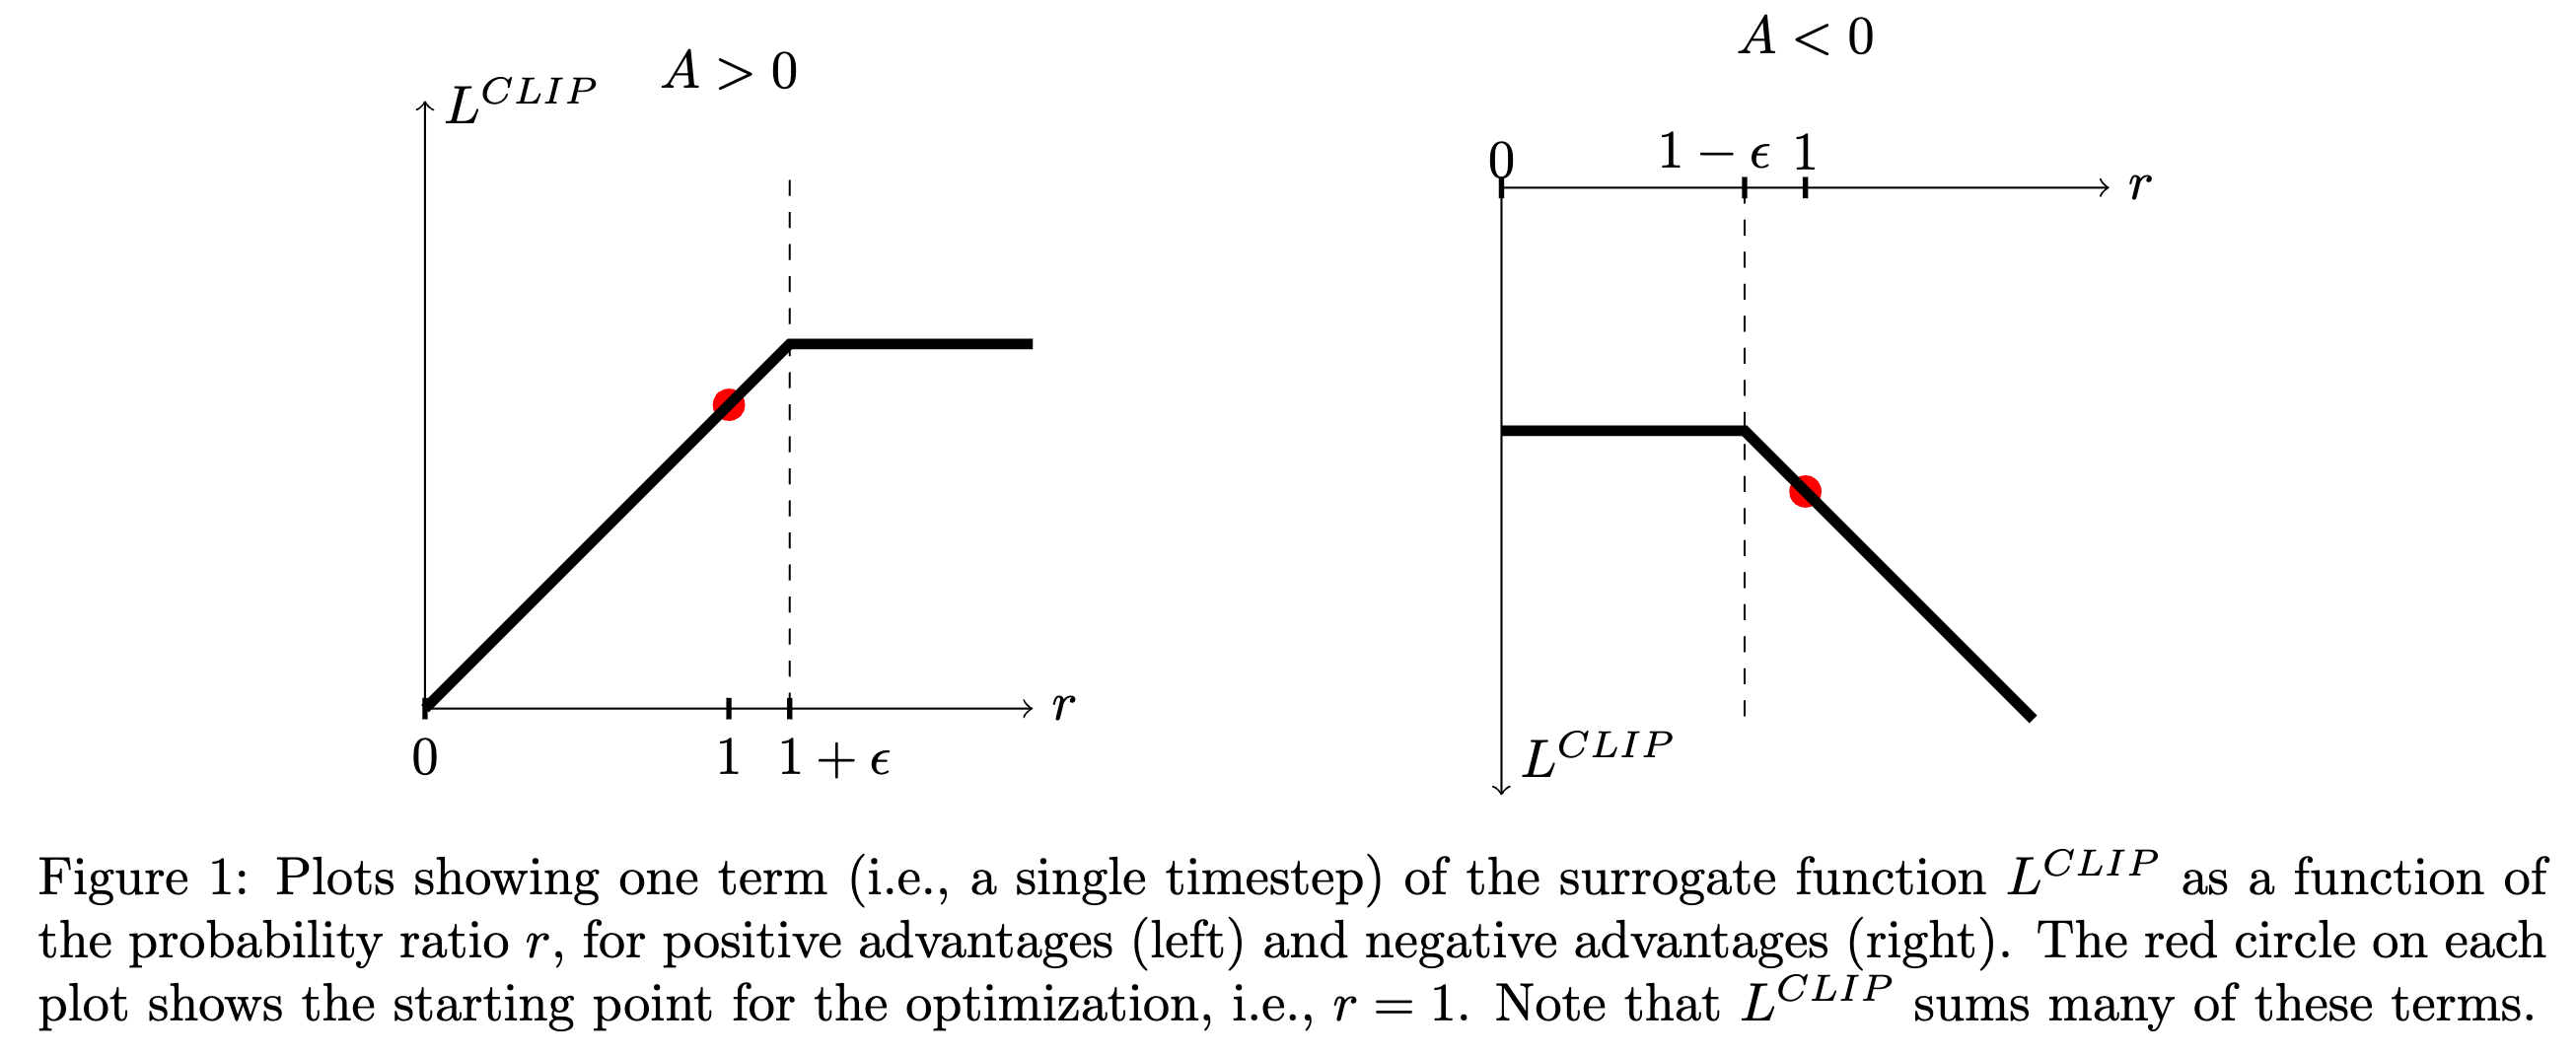
* 代理目标奖励函数
在 PPO（近端策略优化）论文的 Figure 2 中，** 线性插值因子（linear interpolation factor）** 是理解代理目标函数$L^{\text{CLIP}}$与原始目标$L^{\text{CPI}}$关系的关键。\
Figure 2 的实验基于连续控制问题，通过策略更新方向的线性插值（即从旧策略$\theta_{\text{old}}$到新策略$\theta_{\text{new}}$的插值），展示了多个目标函数的变化趋势。具体机制如下：
- 插值公式：
    - 设插值因子为$\epsilon \in [0, 1]$，中间策略为$\theta_{\epsilon} = \theta_{\text{old}} + \epsilon (\theta_{\text{new}} - \theta_{\text{old}})$。
    - 当$\epsilon = 0$时，策略为旧策略；
    - 当$\epsilon = 1$时，策略为新策略。
    - 中间值表示不同幅度的策略更新。

- 目标函数对比：
    - 实验对比了$L^{\text{CLIP}}$（裁剪后的代理目标）与$L^{\text{CPI}}$（保守策略迭代的原始目标），以及可能的其他目标（如 KL 散度、奖励函数等）。
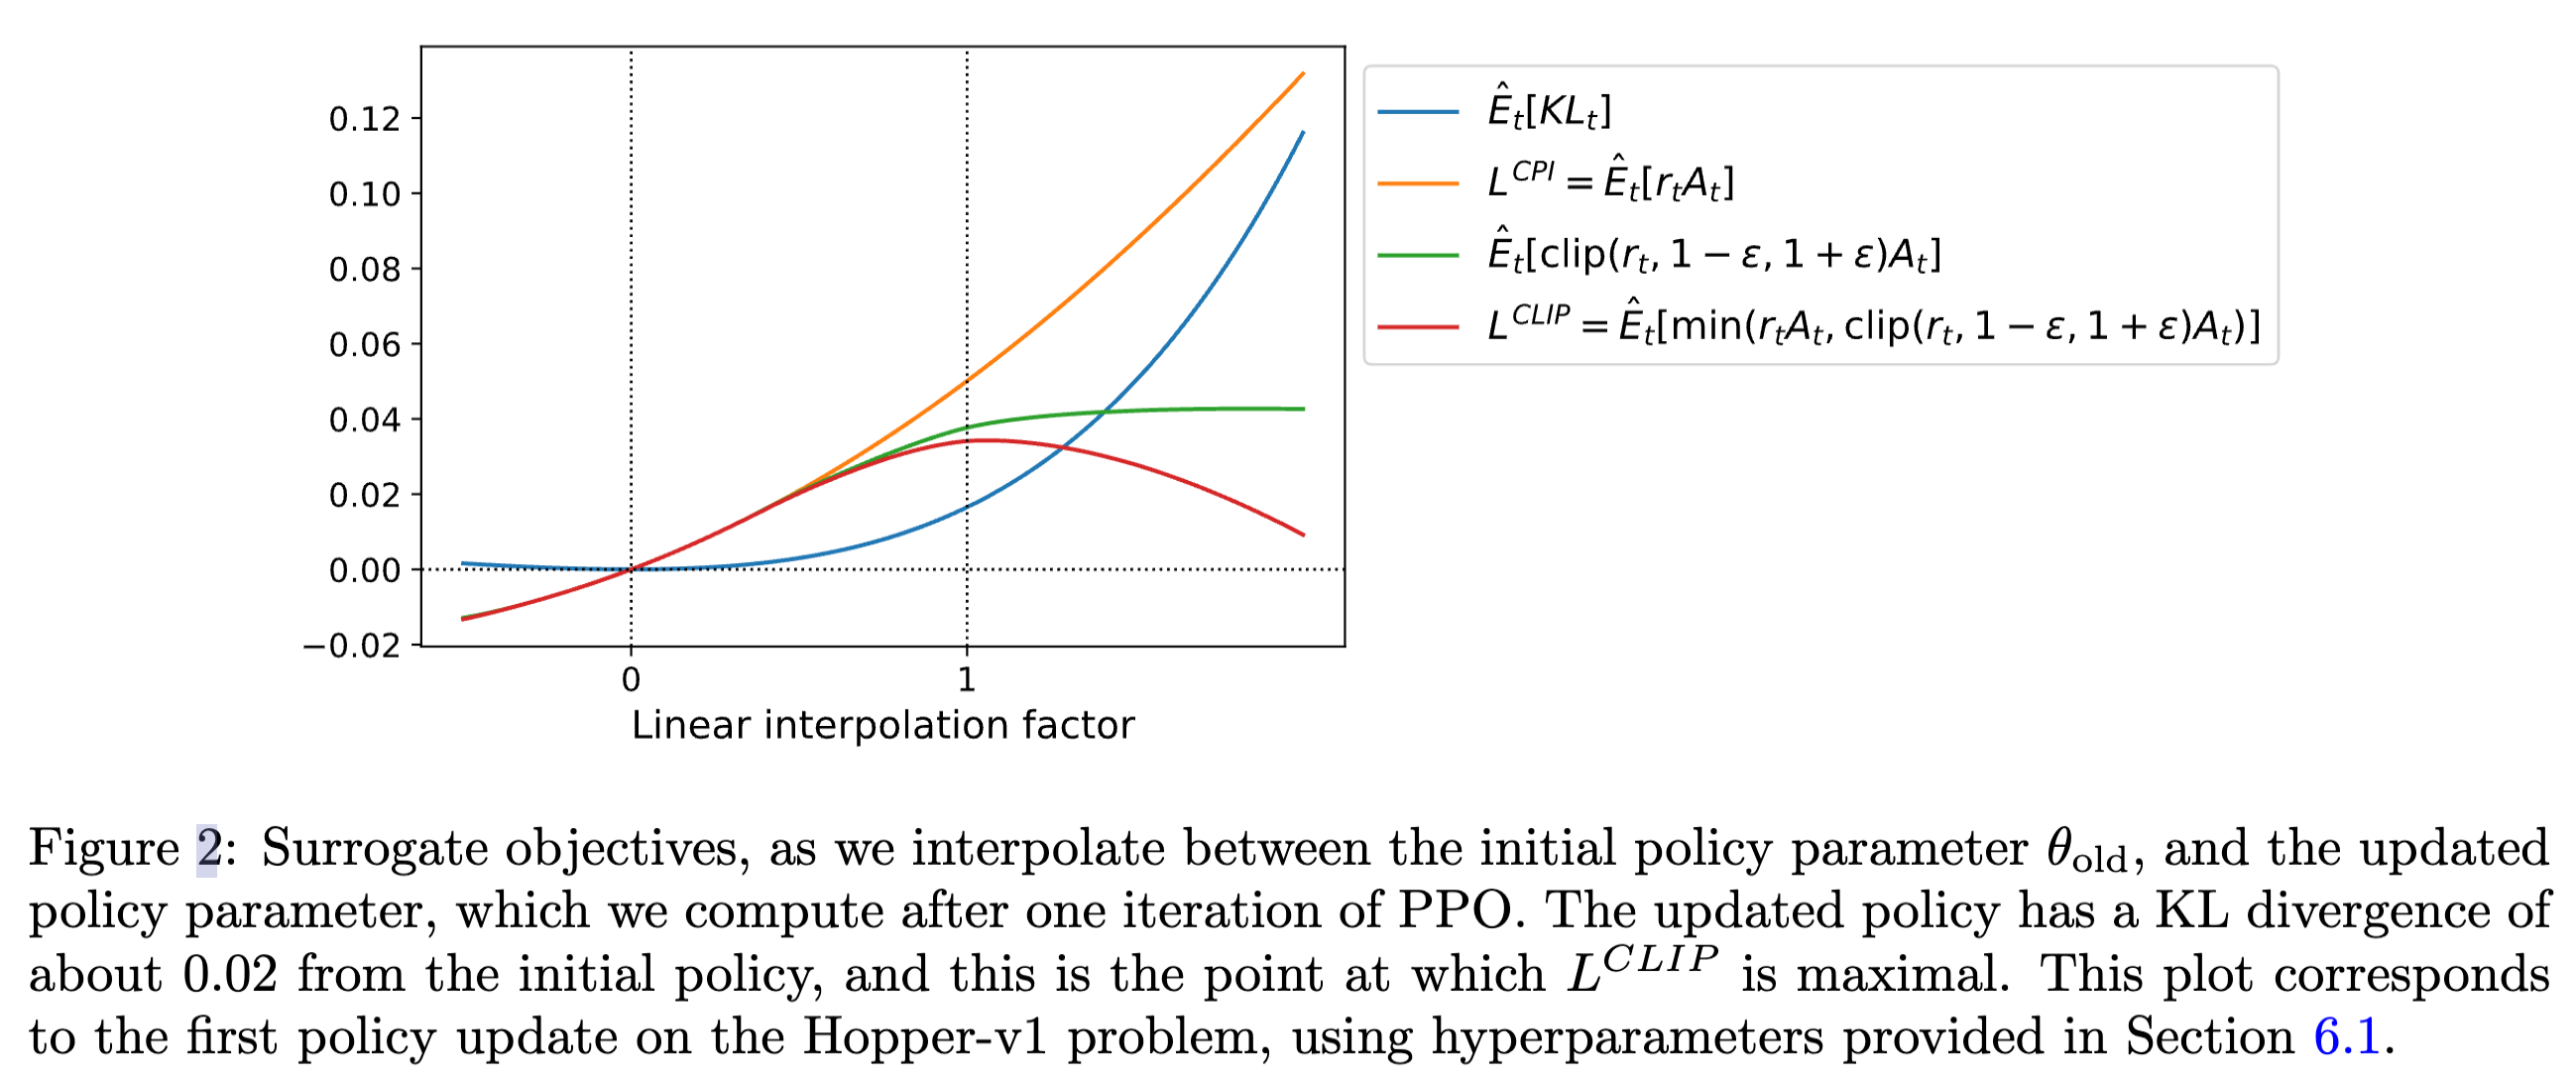

## 4. PPO 2: Adaptive KL Penalty Coefficient


In [11]:
t = torch.tensor(list(range(10)), dtype=torch.float32)
t

tensor([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [12]:
t.dtype

torch.float32